# Linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# model
class MyLineReg():
    def __init__(self, n_iter=100, learning_rate=0.1, weights=None):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = weights
        
        
    def __str__(self):
        params = ", ".join(f"{key}={value}" for key, value in self.__dict__.items())
        return f"{__class__.__name__} class: {params}"
    
    
    def MSE(self, y_pred, y):
        return np.sum((y_pred - y)**2 / len(y))
    
    
    def predict(self, X):
        X = np.insert(X, 0, np.ones(len(X)), axis=1)
        return X @ self.weights
    
    
    def printLog(self, iter, y_pred, y):
        print(f"iter: {iter} \tloss: {self.MSE(y_pred, y)}")
        
    
    def fit(self, x, y, verbose=False):
        X = np.insert(x, 0, np.ones(len(x)), axis=1)
        self.weights = np.ones(X.shape[1])
        
        for iter in range(self.n_iter):
            y_pred = self.predict(x)
            grad = 2*(y_pred - y) @ X / len(X)
            self.weights -= self.learning_rate * grad
            
            if verbose and iter % verbose == 0:
                self.printLog(iter, y_pred, y)
            
            
    def get_coef(self):
        return self.weights[1::]

In [4]:
# data generation
def linear_func(x):
    return 2 * x + 1


dataset_size = 200
x = np.random.rand(dataset_size) * 10
y = linear_func(x) + np.random.randn(dataset_size) * 2

train_size = 0.5
n = int(train_size * len(x))
x_train, x_test, y_train, y_test = x[:n], x[n::], y[:n], y[n::]

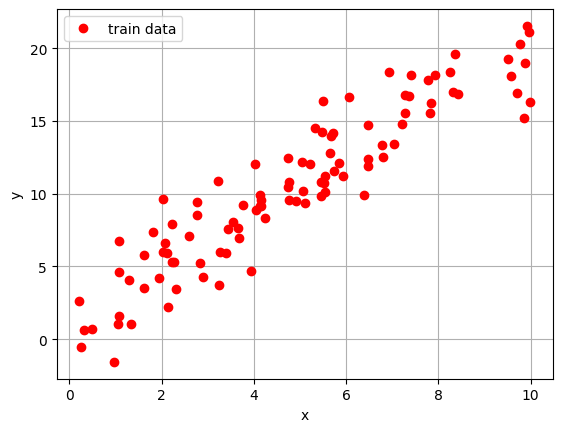

In [12]:
# draw train data
def drawDataset(x, y, name, colour='r'):
    plt.plot(x, y, colour + 'o', label=name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)


drawDataset(x_train, y_train, "train data")
plt.show()

In [37]:
# train model
X = np.reshape(x_train, (len(x_train), 1))
myLineReg = MyLineReg(100, 0.01)
myLineReg.fit(X, y_train, 10)

iter: 0 	loss: 31.3868601011505
iter: 10 	loss: 4.02496300737097
iter: 20 	loss: 4.024860738520239
iter: 30 	loss: 4.024767296997468
iter: 40 	loss: 4.024681855461056
iter: 50 	loss: 4.024603728992998
iter: 60 	loss: 4.024532291314466
iter: 70 	loss: 4.024466969765432
iter: 80 	loss: 4.024407240714101
iter: 90 	loss: 4.024352625359356


In [38]:
# display weights
weights = myLineReg.weights
weights

array([1.17504762, 1.91882907])

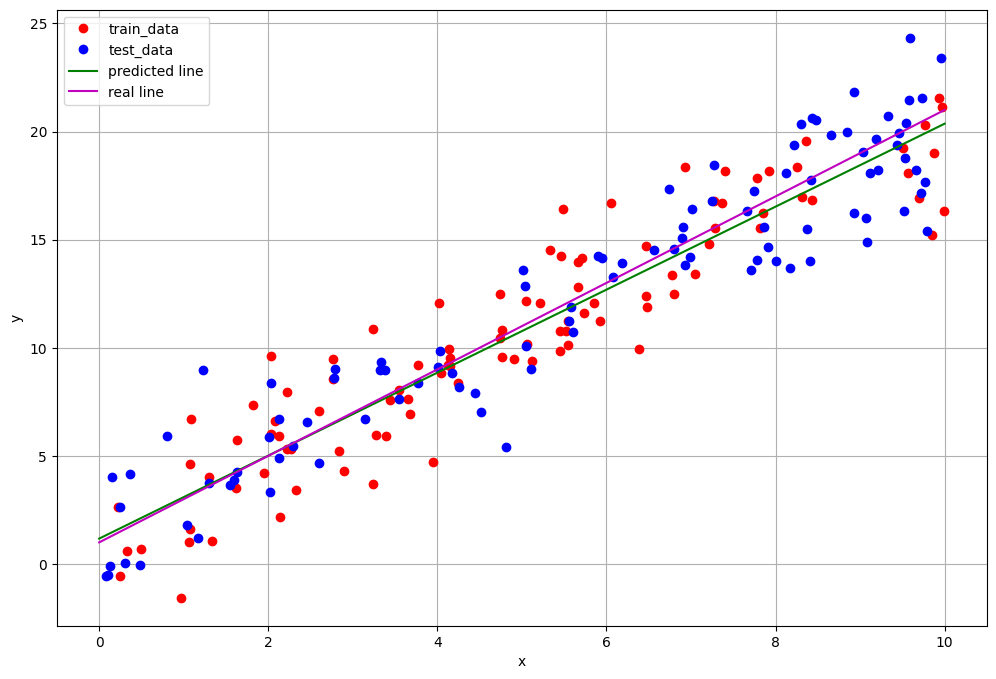

In [41]:
# draw result
x_line = np.linspace(0, 10, 100)
y_line = weights[1] * x_line + weights[0]

plt.figure(figsize=(12, 8))
drawDataset(x_train, y_train, "train_data")
drawDataset(x_test, y_test, "test_data", 'b')
plt.plot(x_line, y_line, 'g-', label="predicted line")
plt.plot(x_line, linear_func(x_line), 'm-', label="real line")
plt.legend()
plt.show()